## Transfer Learning using CIFAR-10 data
You will work with the CIFAR-10 Dataset. This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:
airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

To illustrate the power and concept of transfer learning, you will train a CNN on just the classes (airplane, automobile, bird, cat, deer). Then you will train just the last layer(s) of the network on the classes (dog, frog, horse, ship, truck) and see how well the features learned on (airplane, automobile, bird, cat, deer) help with classifying (dog, frog, horse, ship, truck).


In [9]:
from __future__ import print_function
import datetime
import numpy as np
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [10]:
#used to help some of the timing functions
now = datetime.datetime.now

In [11]:
## This just handles some variability in how the input data is loaded
img_rows, img_cols = 32, 32
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 3)

In [12]:
## To simplify things, write a function to include all the training steps
## As input, function takes a model, training set, test set, and the number of classes
## Inside the model object will be the state about which layers we are freezing and which we are training

def train_model(model, train, test, num_classes):
    x_train = train[0].reshape((train[0].shape[0],) + input_shape)
    x_test = test[0].reshape((test[0].shape[0],) + input_shape)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(train[1], num_classes)
    y_test = keras.utils.to_categorical(test[1], num_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.rmsprop(lr=.001),
                  metrics=['accuracy'])

    t = now()
    model.fit(x_train, y_train,
              batch_size=64,
              epochs=10,
              verbose=1,
              validation_data=(x_test, y_test))
    print('Training time: %s' % (now() - t))

    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

In [13]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

# create two datasets: one with classes below 5 and one with 5 and above
x_train_lt5 = x_train[y_train < 5]
y_train_lt5 = y_train[y_train < 5]
x_test_lt5 = x_test[y_test < 5]
y_test_lt5 = y_test[y_test < 5]

x_train_gte5 = x_train[y_train >= 5]
y_train_gte5 = y_train[y_train >= 5] - 5
x_test_gte5 = x_test[y_test >= 5]
y_test_gte5 = y_test[y_test >= 5] - 5

#num_classes = 10

#y_train_lt5 = keras.utils.to_categorical(y_train, num_classes)
#y_train_gte5 = keras.utils.to_categorical(y_train, num_classes)

#y_test_lt5 = keras.utils.to_categorical(y_test, num_classes)
#y_test_gte5 = keras.utils.to_categorical(y_test, num_classes)

# let's make everything float and scale
#x_train_lt5 = x_train_lt5.astype('float32')
#x_train_gte5 = x_train_gte5.astype('float32')

#x_test_lt5 = x_test_lt5.astype('float32')
#x_test_gte5 = x_test_gte5.astype('float32')

#x_train_lt5 /= 255
#x_train_gte5 /= 255

#x_test_lt5 /= 255
#x_test_gte5 /= 255
print(x_train.shape, 'train samples')


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
(50000, 32, 32, 3) train samples


In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

def build_cnn_model(input_shape, num_classes):
    model = Sequential()

    # 1. Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.2))

    # 2. Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.2))

    # 3. Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.2))

    # Fully Connected
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    return model


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def train_model(model, train, test, num_classes):
    x_train = train[0].reshape((train[0].shape[0],) + input_shape)
    x_test = test[0].reshape((test[0].shape[0],) + input_shape)
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.

    y_train = keras.utils.to_categorical(train[1], num_classes)
    y_test = keras.utils.to_categorical(test[1], num_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
                  metrics=['accuracy'])

    t = now()
    history = model.fit(x_train, y_train,
                        batch_size=64,
                        epochs=10,
                        verbose=1,
                        validation_data=(x_test, y_test))
    print('Training time: %s' % (now() - t))

    print("\nEpoch Results:")
    for i in range(10):
        print(f"Epoch {i+1}: Train Acc = {history.history['accuracy'][i]:.4f}, "
              f"Val Acc = {history.history['val_accuracy'][i]:.4f}, "
              f"Train Loss = {history.history['loss'][i]:.4f}, "
              f"Val Loss = {history.history['val_loss'][i]:.4f}")

    # Model evalution
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nFinal Test Loss:', score[0])
    print('Final Test Accuracy:', score[1])

    # Graphs
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'C{i}' for i in range(num_classes)],
                yticklabels=[f'C{i}' for i in range(num_classes)])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.4098 - loss: 1.3625 - val_accuracy: 0.6344 - val_loss: 0.9051
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6190 - loss: 0.9601 - val_accuracy: 0.7006 - val_loss: 0.7817
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6886 - loss: 0.7996 - val_accuracy: 0.7344 - val_loss: 0.6812
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7252 - loss: 0.7218 - val_accuracy: 0.7288 - val_loss: 0.6874
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7474 - loss: 0.6615 - val_accuracy: 0.7482 - val_loss: 0.6533
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7685 - loss: 0.6186 - val_accuracy: 0.7690 - val_loss: 0.6132
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7808 - loss: 0.5797 - val_accuracy: 0.7414 - val_loss: 0.6929
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7975 - loss: 0.5423 - val_accuracy: 0

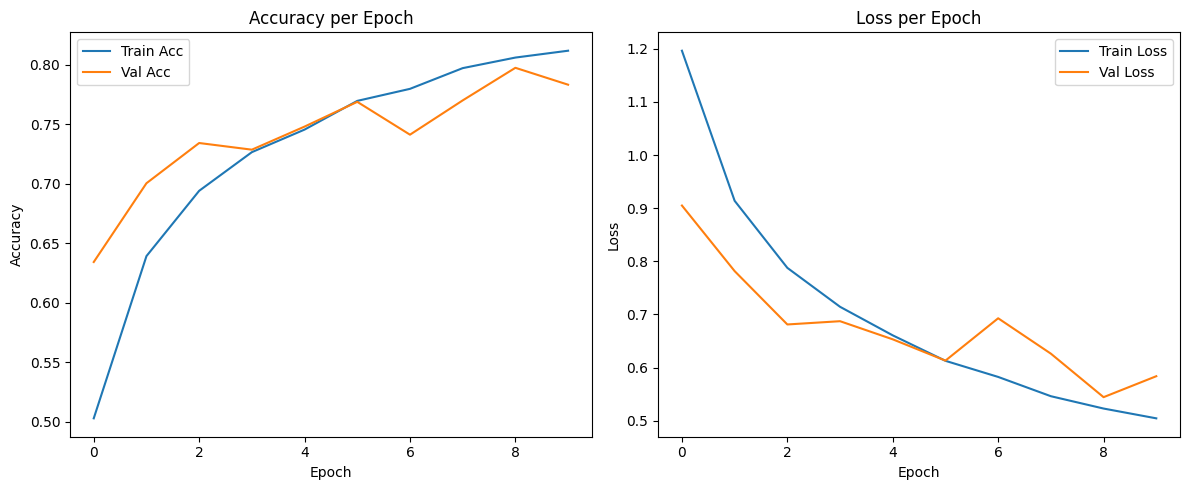

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


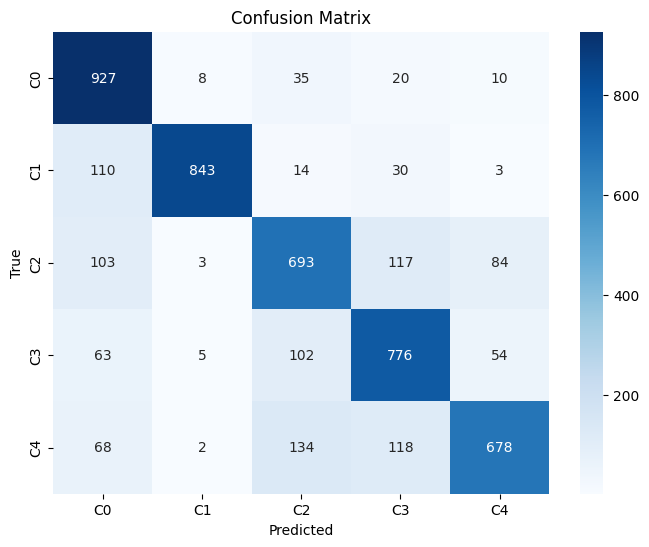

In [16]:
train = (x_train_lt5, y_train_lt5)
test = (x_test_lt5, y_test_lt5)
num_classes = 5

model = build_cnn_model(input_shape, num_classes)
train_model(model, train, test, num_classes)


**I Used Inception V3**

In [17]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.datasets import cifar10
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

# dog(5), frog(6), horse(7), ship(8), truck(9)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.flatten()
y_test = y_test.flatten()

selected_classes = [5, 6, 7, 8, 9]
train_filter = np.isin(y_train, selected_classes)
test_filter = np.isin(y_test, selected_classes)

x_train = x_train[train_filter]
y_train = y_train[train_filter]
x_test = x_test[test_filter]
y_test = y_test[test_filter]

y_train = np.array([selected_classes.index(y) for y in y_train])
y_test = np.array([selected_classes.index(y) for y in y_test])

def resize_batch(images, size):
    return np.array([tf.image.resize(img, size).numpy() for img in images])

img_size = (150, 150)
x_train_resized = resize_batch(x_train, img_size)
x_test_resized = resize_batch(x_test, img_size)

x_train_preprocessed = preprocess_input(x_train_resized)
x_test_preprocessed = preprocess_input(x_test_resized)

# One-hot encoding
y_train_cat = to_categorical(y_train, 5)
y_test_cat = to_categorical(y_test, 5)


In [18]:

def create_inception_model(freeze_until_layer='all'):
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

    if freeze_until_layer == 'all':
        for layer in base_model.layers:
            layer.trainable = False
    elif freeze_until_layer == 'fc_only':
        #Only fully connected ve output layers
        for layer in base_model.layers:
            layer.trainable = False
        for layer in base_model.layers[-10:]:  
            layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [19]:
def train_and_evaluate(model, title):
    history = model.fit(x_train_preprocessed, y_train_cat,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_test_preprocessed, y_test_cat),
                    verbose=1)

    # Graphs
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Confusion Matrix
    y_pred = model.predict(x_test_preprocessed)
    y_pred_classes = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=selected_classes,
                yticklabels=selected_classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

   # Classification Report
    print(f"\nClassification Report - {title}")
    print(classification_report(y_test, y_pred_classes, target_names=[str(cls) for cls in selected_classes]))


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 54ms/step - accuracy: 0.8190 - loss: 0.7148 - val_accuracy: 0.9236 - val_loss: 0.2625
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9136 - loss: 0.2955 - val_accuracy: 0.9308 - val_loss: 0.2518
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.9225 - loss: 0.2505 - val_accuracy: 0.9272 - val_loss: 0.2702
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.9268 - loss: 0.2493 - val_accuracy: 0.9258 - val_loss: 0.2858
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.9334 - loss: 0.2288 - val_accuracy: 0.9404 - val_loss: 0.2359
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.9355 - loss: 0.2175 - val_accuracy: 0.9370 - val_loss: 0.2536
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.9383 - loss: 0.2104 - val_accuracy: 0.9340 - val_loss: 0.3003
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━

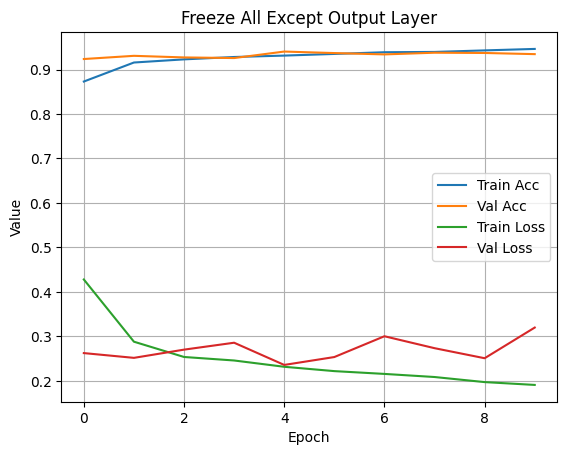

157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step


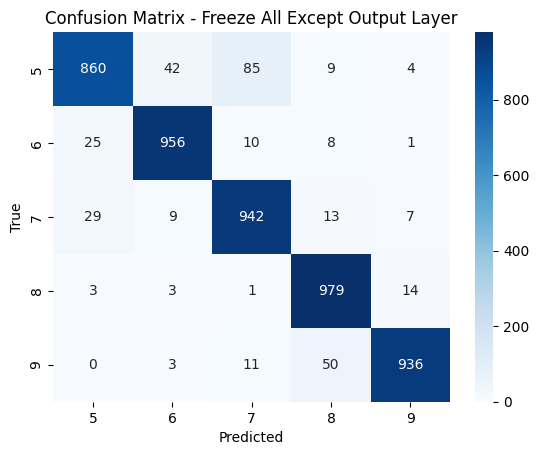


Classification Report - Freeze All Except Output Layer
              precision    recall  f1-score   support

           5       0.94      0.86      0.90      1000
           6       0.94      0.96      0.95      1000
           7       0.90      0.94      0.92      1000
           8       0.92      0.98      0.95      1000
           9       0.97      0.94      0.95      1000

    accuracy                           0.93      5000
   macro avg       0.94      0.93      0.93      5000
weighted avg       0.94      0.93      0.93      5000



Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 74, 74, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 22,328,620 (85.18 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 262,919 (1.00 MB)

In [20]:
model_all_frozen = create_inception_model('all')
train_and_evaluate(model_all_frozen, "Freeze All Except Output Layer")
model_all_frozen.summary()


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 56s 52ms/step - accuracy: 0.8294 - loss: 0.6318 - val_accuracy: 0.9306 - val_loss: 0.2249
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9157 - loss: 0.2787 - val_accuracy: 0.9232 - val_loss: 0.2627
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9236 - loss: 0.2569 - val_accuracy: 0.9412 - val_loss: 0.2025
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9309 - loss: 0.2295 - val_accuracy: 0.9320 - val_loss: 0.2525
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9318 - loss: 0.2328 - val_accuracy: 0.9386 - val_loss: 0.2608
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9379 - loss: 0.2122 - val_accuracy: 0.9352 - val_loss: 0.2438
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9384 - loss: 0.2095 - val_accuracy: 0.9372 - val_loss: 0.2716
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.9423 - loss: 0.2014 - 

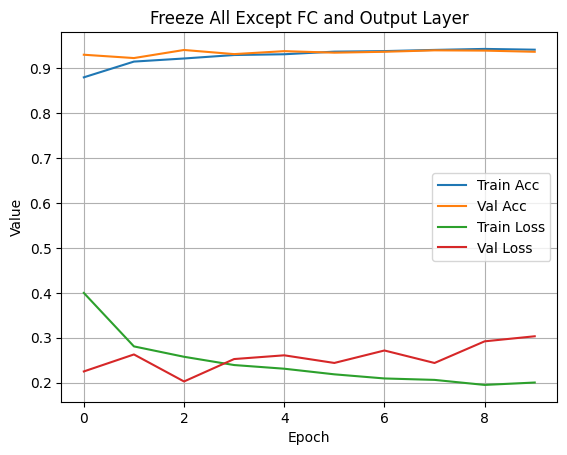

157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step


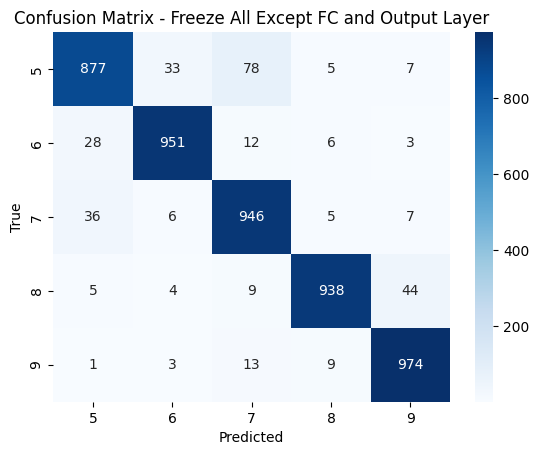


Classification Report - Freeze All Except FC and Output Layer
              precision    recall  f1-score   support

           5       0.93      0.88      0.90      1000
           6       0.95      0.95      0.95      1000
           7       0.89      0.95      0.92      1000
           8       0.97      0.94      0.96      1000
           9       0.94      0.97      0.96      1000

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_100 (Conv2D)       │ (None, 74, 74, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 74, 74, 32)     │             96 │ conv2d_100[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 74, 74, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_101 (Conv2D)       │ (None, 72, 72, 32)     │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 72, 72, 32)     │             96 │ conv2d_101[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 72, 72, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_102 (Conv2D)       │ (None, 72, 72, 64)     │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 72, 72, 64)     │            192 │ conv2d_102[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 72, 72, 64)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 35, 35, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_103 (Conv2D)       │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 35, 35, 80)     │            240 │ conv2d_103[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 35, 35, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_104 (Conv2D)  

 Total params: 22,328,812 (85.18 MB)

 Trainable params: 263,109 (1.00 MB)

 Non-trainable params: 21,802,592 (83.17 MB)

 Optimizer params: 263,111 (1.00 MB)

In [21]:
model_fc_frozen = create_inception_model('fc_only')
train_and_evaluate(model_fc_frozen, "Freeze All Except FC and Output Layer")
model_fc_frozen.summary()


**1. How many trainable parameters are there in each case?**

Freeze all layers except the output layer= Trainable params: 262,917 (1.00 MB)

Freeze all layers except the fully connected and output layer=Trainable params: 263,109 (1.00 MB)

**2. Which fine-tuning performs better in terms of classification accuracy and why?**

Accuracy:
- Freeze all layers except the output layer:

Training accuracy ≈ 93%

Validation accuracy ≈ 93%

- Freeze all layers except the fully connected and output layer:

Training accuracy ≈ 94%

Validation accuracy ≈ 94.5%

Result: The second model provides higher accuracy in both training and validation.

The “Freeze All Except FC and Output Layer” approach performs better.

The reason is:

- Higher accuracy

- Lower and stable verification loss

**3. Why is fine-tuning much faster than the initial training of the network?**

In fine-tuning, most or all of the layers (particularly early convolutional layers) are frozen, i.e., their weights are not changed.

This lowers the amount of backpropagation calculations dramatically.

Only the non-frozen layers (i.e., fully connected layers or the output layer) need to compute gradients and update weights.

